# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [18]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [19]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [20]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [22]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

#pass
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
#pass
for i in range(len(learning_rates)):
    svm = LinearSVM()
    lr, reg = learning_rates[i], regularization_strengths[i]
    loss_hist = svm.train(X_train_feats, y_train, lr, reg,
                      num_iters=1500, verbose=True)
    y_train_pred = svm.predict(X_train_feats)
    y_val_pred = svm.predict(X_val_feats)
    accuracy_train = np.mean(y_train == y_train_pred)
    accuracy_val = np.mean(y_val == y_val_pred)
    if max(accuracy_train, accuracy_val) > best_val:
        best_val = max(accuracy_train, accuracy_val)
        best_svm = svm
    results[(lr, reg)] = (accuracy_train, accuracy_val)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 47.845177
iteration 100 / 1500: loss 47.463398
iteration 200 / 1500: loss 47.065838
iteration 300 / 1500: loss 46.689691
iteration 400 / 1500: loss 46.312947
iteration 500 / 1500: loss 45.938373
iteration 600 / 1500: loss 45.564970
iteration 700 / 1500: loss 45.223859
iteration 800 / 1500: loss 44.856168
iteration 900 / 1500: loss 44.509319
iteration 1000 / 1500: loss 44.140046
iteration 1100 / 1500: loss 43.786399
iteration 1200 / 1500: loss 43.450991
iteration 1300 / 1500: loss 43.095762
iteration 1400 / 1500: loss 42.775665
iteration 0 / 1500: loss 380.478716
iteration 100 / 1500: loss 145.314856
iteration 200 / 1500: loss 59.019763
iteration 300 / 1500: loss 27.353781
iteration 400 / 1500: loss 15.738715
iteration 500 / 1500: loss 11.471994
iteration 600 / 1500: loss 9.907108
iteration 700 / 1500: loss 9.332527
iteration 800 / 1500: loss 9.122177
iteration 900 / 1500: loss 9.044854
iteration 1000 / 1500: loss 9.016474
iteration 1100 / 1500: loss 9.005981
it

In [23]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.355


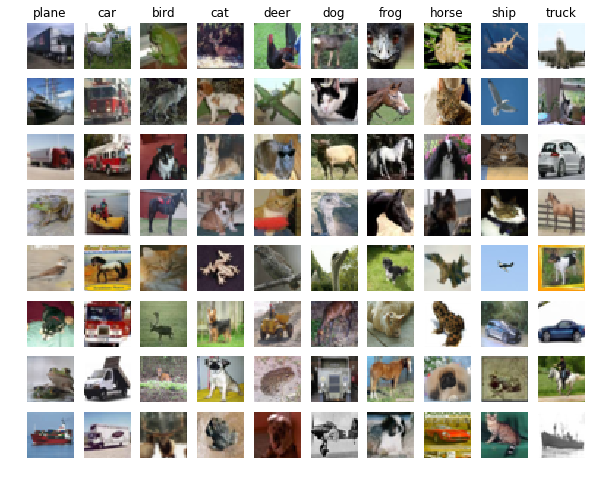

In [24]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [16]:
print(X_train_feats.shape)

(49000, 155)


In [45]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
#hidden_dim = 400
num_classes = 10

##net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
#pass
best_acc = -1
input_size = 32 * 32 * 3
#input_size = input_dim
best_stats = None

#hidden_size_choice = [x*100+50 for x in xrange(11)]
hidden_size_choice = [hidden_dim]
reg_choice = [0.1, 0.5, 5, 15, 50, 100, 1000]
learning_rate_choice = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1, 1]
batch_size_choice = [8, 40, 80, 160, 500, 1000]


#hidden_size_choice = [400]
#hidden_size_choice = [hidden_dim]
#learning_rate_choice = [1.8, 1.7, 1.6, 1.5]
#reg_choice = [0.02, 0.05, 0.1]
#reg_choice = [0.01, 0.011]
#batch_size_choice =[500]
num_iters_choice = [1200]

for batch_size_curr in batch_size_choice:
    for reg_cur in reg_choice:
        for learning_rate_curr in learning_rate_choice:
            for hidden_size_curr in hidden_size_choice:
                for num_iters_curr in num_iters_choice:
                    #print 
                    print ("current training hidden_size:",hidden_size_curr)
                    print ("current training learning_rate:",learning_rate_curr)
                    print ("current training reg:",reg_cur)
                    print ("current training batch_size:",batch_size_curr)
                    net = TwoLayerNet(input_dim, hidden_dim, num_classes)
                    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                            num_iters=num_iters_curr, batch_size=batch_size_curr,
                            learning_rate=learning_rate_curr, learning_rate_decay=0.95,
                            reg=reg_cur, verbose=True)
                    val_acc = (net.predict(X_val_feats) == y_val).mean()
                    print ("current val_acc:",val_acc)
                    if val_acc>best_acc:
                        best_acc = val_acc
                        best_net = net
                        best_stats = stats
                        best_learning_rate = learning_rate_curr
                        best_reg = reg_cur
                        best_batch_size = batch_size_curr
                        #print 
                        print ("best_acc:",best_acc)
                        print ("best hidden_size:",best_net.params['W1'].shape[1])
                        print ("best learning_rate:",best_learning_rate)
                        print ("best reg:",best_reg)
                        print ("best batch_size:",best_batch_size)
                        #print
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

current training hidden_size: 500
current training learning_rate: 1.8
current training reg: 0.01
current training batch_size: 500
iteration 0 / 1200: loss 2.302589
iteration 100 / 1200: loss 1.582429
iteration 200 / 1200: loss 1.602525
iteration 300 / 1200: loss 1.581607
iteration 400 / 1200: loss 1.533709
iteration 500 / 1200: loss 1.558981
iteration 600 / 1200: loss 1.522715
iteration 700 / 1200: loss 1.540166
iteration 800 / 1200: loss 1.538707
iteration 900 / 1200: loss 1.473902
iteration 1000 / 1200: loss 1.479422
iteration 1100 / 1200: loss 1.484233
current val_acc: 0.541
best_acc: 0.541
best hidden_size: 500
best learning_rate: 1.8
best reg: 0.01
best batch_size: 500
current training hidden_size: 500
current training learning_rate: 1.7
current training reg: 0.01
current training batch_size: 500
iteration 0 / 1200: loss 2.302589
iteration 100 / 1200: loss 1.584174
iteration 200 / 1200: loss 1.472174
iteration 300 / 1200: loss 1.527255
iteration 400 / 1200: loss 1.551304
iteration

In [46]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

#net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None
best_stats = None
################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
best_acc = -1
input_size = 32 * 32 * 3

learning_rate_choice = [1.8,1.7, 1.6, 1.5]
reg_choice = [0.01, 0.011]
num_iters_choice = [800]

for learning_rate_curr in learning_rate_choice:
    for reg_cur in reg_choice:    
        for num_iters_curr in num_iters_choice:
            print("") 
            print ("current training learning_rate:",learning_rate_curr)
            print ("current training reg:",reg_cur)
            net = TwoLayerNet(input_dim, hidden_dim, num_classes)
            stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                        num_iters=num_iters_curr, batch_size=1500,
                        learning_rate=learning_rate_curr, learning_rate_decay=0.95,
                        reg=reg_cur, verbose=True)
            val_acc = (net.predict(X_val_feats) == y_val).mean()
            print ("current val_acc:",val_acc)
            if val_acc>best_acc:
                best_acc = val_acc
                best_net = net
                best_stats = stats
                print("") 
                print ("best_acc:",best_acc)
                #print ("best learning_rate:",best_net.hyper_params['learning_rate'])
                #print ("best reg:",best_net.hyper_params['reg'])
                print ("")
################################################################################
#                              END OF YOUR CODE                                #
################################################################################


current training learning_rate: 1.8
current training reg: 0.01
iteration 0 / 800: loss 2.302589
iteration 100 / 800: loss 1.563783
iteration 200 / 800: loss 1.537263
iteration 300 / 800: loss 1.554023
iteration 400 / 800: loss 1.490258
iteration 500 / 800: loss 1.584342
iteration 600 / 800: loss 1.636048
iteration 700 / 800: loss 1.503646
current val_acc: 0.531

best_acc: 0.531


current training learning_rate: 1.8
current training reg: 0.011
iteration 0 / 800: loss 2.302590
iteration 100 / 800: loss 1.522251
iteration 200 / 800: loss 1.617714
iteration 300 / 800: loss 1.584413
iteration 400 / 800: loss 1.600475
iteration 500 / 800: loss 1.564012
iteration 600 / 800: loss 1.523132
iteration 700 / 800: loss 1.551894
current val_acc: 0.474

current training learning_rate: 1.7
current training reg: 0.01
iteration 0 / 800: loss 2.302589
iteration 100 / 800: loss 1.580704
iteration 200 / 800: loss 1.488487
iteration 300 / 800: loss 1.557951
iteration 400 / 800: loss 1.533481
iteration 500 

In [32]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.09


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!